# Semi-Supervised Learning for Instance Segmentation

## Introduction

Semi-supervised learning (SSL) is a machine learning paradigm that leverages both labeled and unlabeled data to improve model performance, especially when labeled data is scarce. In segmentation tasks, SSL methods help in learning better representations by utilizing the abundance of unlabeled images. This notebook implements SSL techniques for instance segmentation on the Dresden Surgical Anatomy Dataset using YOLOv12-Seg as the baseline model.

## Dataset Description & Splitting Strategy

The Dresden Surgical Anatomy Dataset is used for instance segmentation of surgical anatomy. The dataset is split as follows:
- 80% Training (further split into 20% labeled and 80% unlabeled)
- 10% Validation
- 10% Testing

Image counts after splitting will be displayed in the code.

**Group Members**
1. Asfar Hossain Sitab (2022-3-60-275)
2. Parmita Hossain Simia (2022-3-60-253)
3. Kamran Hasan (2022-2-60-077)
4. Nusrat Jahan Oishi (2022-2-60-033)

In [1]:
# Install dependencies
!pip install --upgrade ultralytics --no-deps

import ultralytics
from ultralytics import YOLO
import os
import yaml
import shutil
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

# Dataset path
dataset_path = '/kaggle/input/the-dresden-surgical-anatomy-dataset/Dresden Dataset'

# Load original data.yaml
data_yaml_path = os.path.join(dataset_path, 'dataset.yaml')
with open(data_yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)

print("Dataset loaded.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Dataset loaded.


In [2]:
# Dataset Splitting
images_dir = os.path.join(dataset_path, 'images')
labels_dir = os.path.join(dataset_path, 'labels')

# Get all images
all_images = [f for f in os.listdir(os.path.join(images_dir, 'train')) if f.endswith(('.jpg', '.png'))]

# Split: 80% train, 10% val, 10% test
train_images, temp = train_test_split(all_images, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(temp, test_size=0.5, random_state=42)

# From train: 20% labeled, 80% unlabeled
labeled_images, unlabeled_images = train_test_split(train_images, test_size=0.8, random_state=42)

# Create directories
splits = {'train': train_images, 'val': val_images, 'test': test_images, 'labeled': labeled_images}
for split, imgs in splits.items():
    os.makedirs(f'/kaggle/working/images/{split}', exist_ok=True)
    os.makedirs(f'/kaggle/working/labels/{split}', exist_ok=True)
    for img in imgs:
        shutil.copy(os.path.join(images_dir, 'train', img), f'/kaggle/working/images/{split}/{img}')
        lbl = img.replace('.jpg', '.txt').replace('.png', '.txt')
        if os.path.exists(os.path.join(labels_dir, 'train', lbl)):
            shutil.copy(os.path.join(labels_dir, 'train', lbl), f'/kaggle/working/labels/{split}/{lbl}')

# Unlabeled: images only
os.makedirs('/kaggle/working/images/unlabeled', exist_ok=True)
for img in unlabeled_images:
    shutil.copy(os.path.join(images_dir, 'train', img), f'/kaggle/working/images/unlabeled/{img}')

# Create data.yaml files
data_yaml_labeled = {
    'path': '/kaggle/working',
    'train': '/kaggle/working/images/labeled',
    'val': '/kaggle/working/images/val',
    'test': '/kaggle/working/images/test',
    'nc': 11,
    'names': data_yaml['names']
}
with open('/kaggle/working/data_labeled.yaml', 'w') as f:
    yaml.dump(data_yaml_labeled, f)

data_yaml_combined = data_yaml_labeled.copy()
data_yaml_combined['train'] = '/kaggle/working/images/train'  # For SSL methods
with open('/kaggle/working/data_combined.yaml', 'w') as f:
    yaml.dump(data_yaml_combined, f)

print(f"Train: {len(train_images)}, Val: {len(val_images)}, Test: {len(test_images)}")
print(f"Labeled: {len(labeled_images)}, Unlabeled: {len(unlabeled_images)}")

Train: 13890, Val: 1736, Test: 1737
Labeled: 2778, Unlabeled: 11112


## Model Overview

**Baseline Model:** YOLOv12-Seg trained only on 20% labeled data.

**SSL Methods:**
1. **Pseudo-Labeling:** Generate pseudo-labels on unlabeled data using baseline, then retrain on labeled + pseudo-labeled.
2. **Mean Teacher:** Use exponential moving average (EMA) of model weights for consistency.
3. **FixMatch:** Apply weak/strong augmentations and consistency loss.

All methods use both labeled and unlabeled data.

In [3]:
# Baseline Training
model_baseline = YOLO('yolo12n-seg.yaml').load('yolo12n.pt')
results_baseline = model_baseline.train(
    data='/kaggle/working/data_labeled.yaml',
    epochs=20,  # Increase for better results
    imgsz=416,
    batch=4,
    device=0,
    project='runs',
    name='baseline',
    exist_ok=True
)
print("Baseline training complete.")

Transferred 691/753 items from pretrained weights
Ultralytics 8.3.233 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_m

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1736       2853      0.504      0.513      0.475      0.307       0.51      0.517      0.479      0.278
        abdominal_wall        215        317      0.406       0.36      0.347      0.266       0.41      0.363      0.352      0.237
                 colon        187        332      0.368       0.44      0.321      0.218      0.369       0.44      0.322      0.206
inferior_mesenteric_artery        150        204      0.456      0.564      0.476      0.248      0.456      0.564       0.47      0.182
      intestinal_veins        143        219      0.554      0.543      0.508      0.277      0.551      0.539      0.478      0.204
                 liver        194        238      0.783      0.787      0.797       0.62      0.787       0.79      0.806      0.577
              pancreas        136        451      0.459      0.361      0.334       0.16      0.483      0.377      0.358      0.141
       small_intestine        156        268      0.407       0.3

# Mean Teacher (Simplified)

In [4]:

# For simplicity, use EMA during training
model_mt = YOLO('yolo12n-seg.yaml').load('yolo12n.pt')
# Custom training loop would be needed for full MT, here using standard train with augmentations
results_mt = model_mt.train(
    data='/kaggle/working/data_combined.yaml',
    epochs=20,
    imgsz=416,
    batch=4,
    device=0,
    augment=True,
    project='runs',
    name='mean_teacher',
    exist_ok=True
)
print("Mean Teacher complete.")

Transferred 691/753 items from pretrained weights
Ultralytics 8.3.233 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data_combined.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=mean_teacher, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overl

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1736       2853      0.663      0.689      0.689      0.481      0.668       0.69      0.693      0.434
        abdominal_wall        215        317      0.493      0.512      0.534      0.422      0.494      0.508      0.531      0.392
                 colon        187        332      0.495      0.507      0.454      0.335      0.499      0.509      0.459      0.316
inferior_mesenteric_artery        150        204      0.695      0.704      0.735      0.461      0.711      0.716      0.751      0.392
      intestinal_veins        143        219      0.754      0.744      0.756      0.471      0.737      0.726      0.746       0.36
                 liver        194        238      0.838      0.869      0.892      0.754      0.834      0.864      0.884      0.701
              pancreas        136        451      0.702      0.472      0.555      0.284      0.709      0.472      0.561      0.251
       small_intestine        156        268      0.527      0.73

## Training Plots

Loss and metric curves for all models.

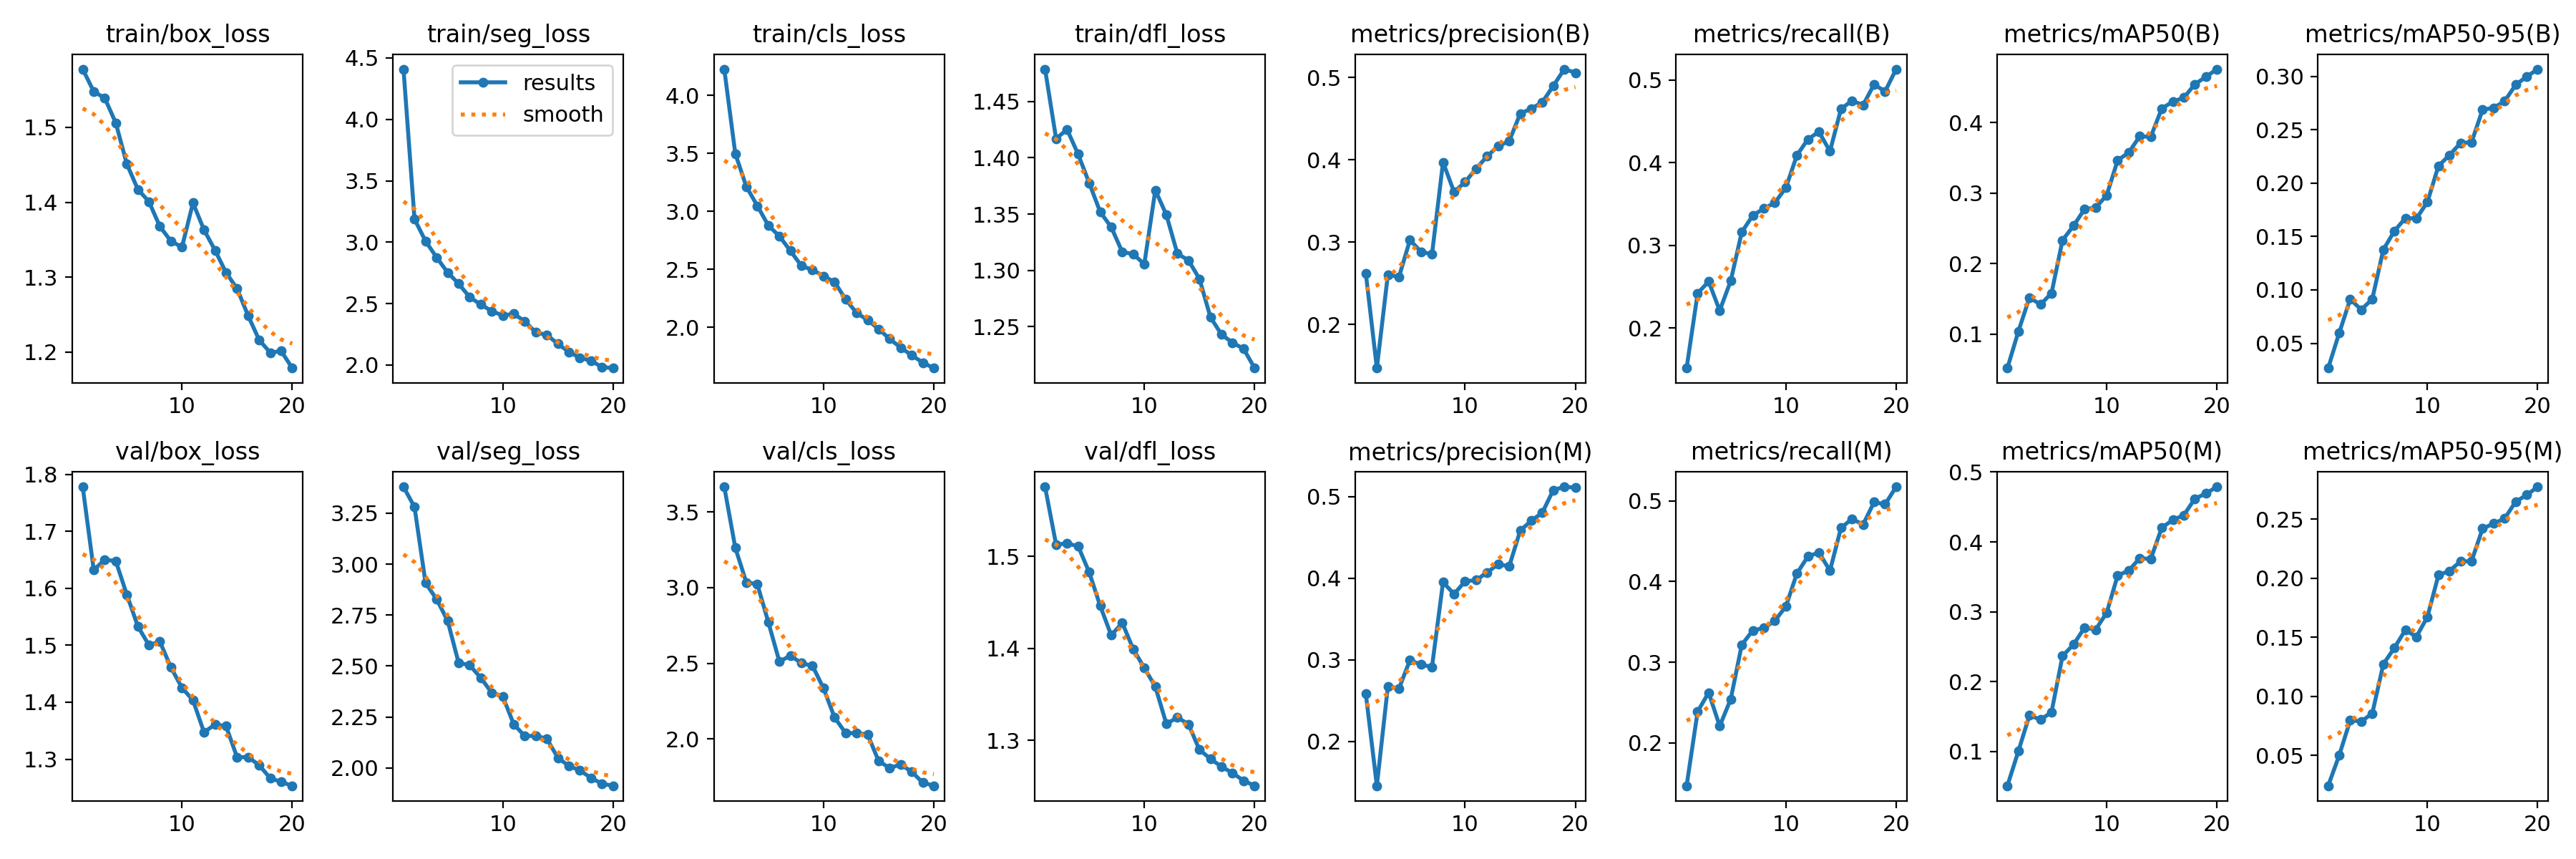

In [5]:
# Plot training results (assuming results have plots)
# For simplicity, display saved plots
from IPython.display import Image
Image('runs/baseline/results.png')
# Similarly for others

In [6]:
# Evaluation
metrics_baseline = model_baseline.val(data='/kaggle/working/data_labeled.yaml')
metrics_mt = model_mt.val(data='/kaggle/working/data_combined.yaml')


# Extract mAP
map50_baseline = metrics_baseline.box.map50
map5095_baseline = metrics_baseline.box.map
# Similarly for mask mAP if available

print("Evaluation complete.")

Ultralytics 8.3.233 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO12n-seg summary (fused): 172 layers, 2,811,289 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3208.7±1049.9 MB/s, size: 334.4 KB)
val: Scanning /kaggle/working/labels/val.cache... 1736 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1736/1736 3.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 109/109 7.6it/s 14.4s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1736       2853      0.504      0.512      0.475      0.307      0.511      0.517      0.478      0.277
        abdominal_wall        215        317      0.406       0.36      0.347      0.267       0.41      0.363      0.352      0.237
                 colon        187        332      0.368       0.44      0.321      0.217       0.37       0.44      0.322      0.206
inferior_mesenteric_artery        150        204      0.459      0.564      0.477      0.247       0.46      0.564      0.471      0.183
      intestinal_veins        143        219      0.559      0.543      0.509      0.277      0.557      0.539      0.478      0.204
                 liver        194        238      0.783      0.788      0.797      0.621      0.787      0.792      0.806      0.576
              pancreas        136        451      0.458      0.361       0.33      0.161      0.478      0.373      0.351      0.137
       small_intestine        156        268      0.406       0.3

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1736       2853      0.663       0.69      0.689      0.481      0.668      0.689      0.691      0.433
        abdominal_wall        215        317      0.494      0.514      0.534      0.422      0.496      0.505      0.531      0.391
                 colon        187        332      0.494      0.509      0.453      0.334      0.501       0.51      0.458      0.314
inferior_mesenteric_artery        150        204      0.695      0.704      0.736       0.46      0.711      0.716       0.75      0.392
      intestinal_veins        143        219       0.75      0.744      0.755      0.474      0.735      0.726      0.742      0.356
                 liver        194        238      0.838      0.869      0.892      0.752      0.834      0.864      0.884        0.7
              pancreas        136        451      0.707      0.476      0.556      0.286      0.712       0.47      0.557      0.246
       small_intestine        156        268      0.528      0.73

**Results Table**

/tmp/ipykernel_20/3501028141.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_idx = class_id % plt.cm.get_cmap('tab10').N
/tmp/ipykernel_20/3501028141.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_norm = plt.cm.get_cmap('tab10')(color_idx)[:3] # Normalized RGB (0-1)


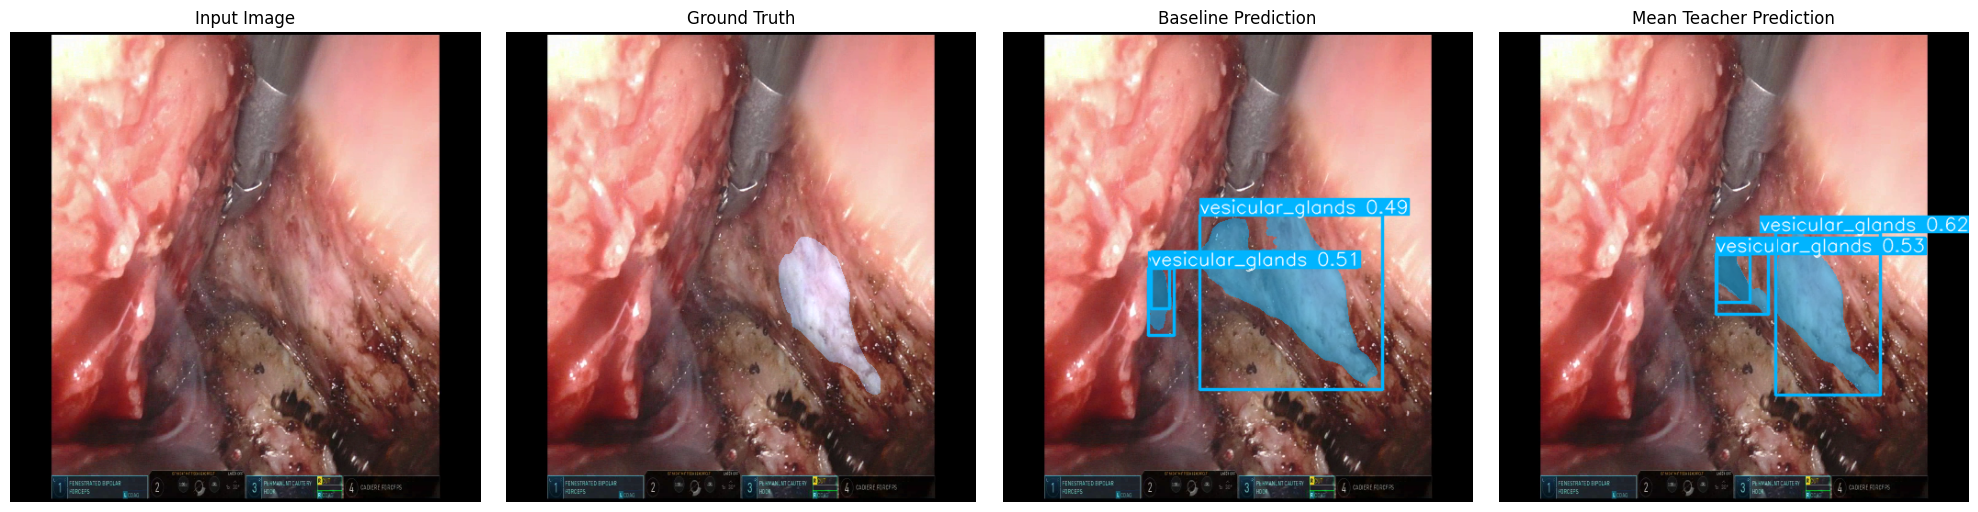

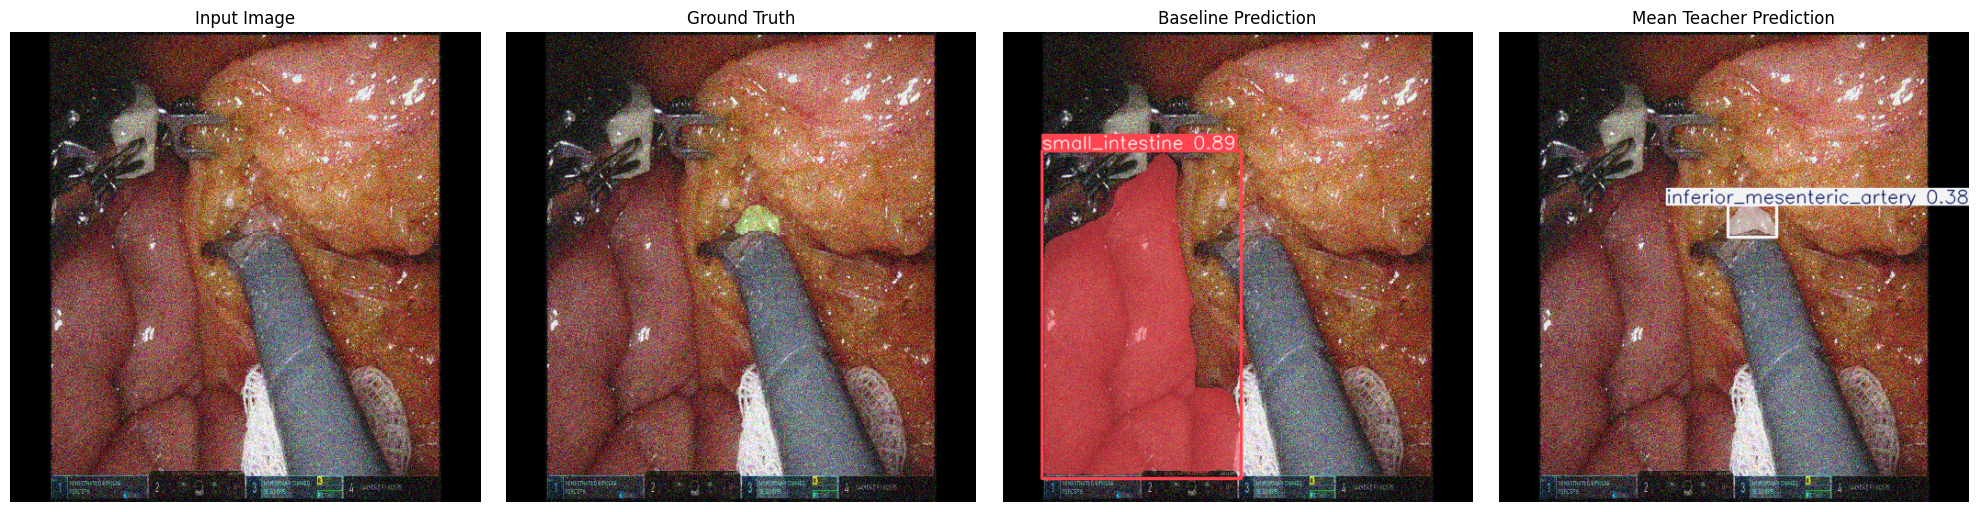

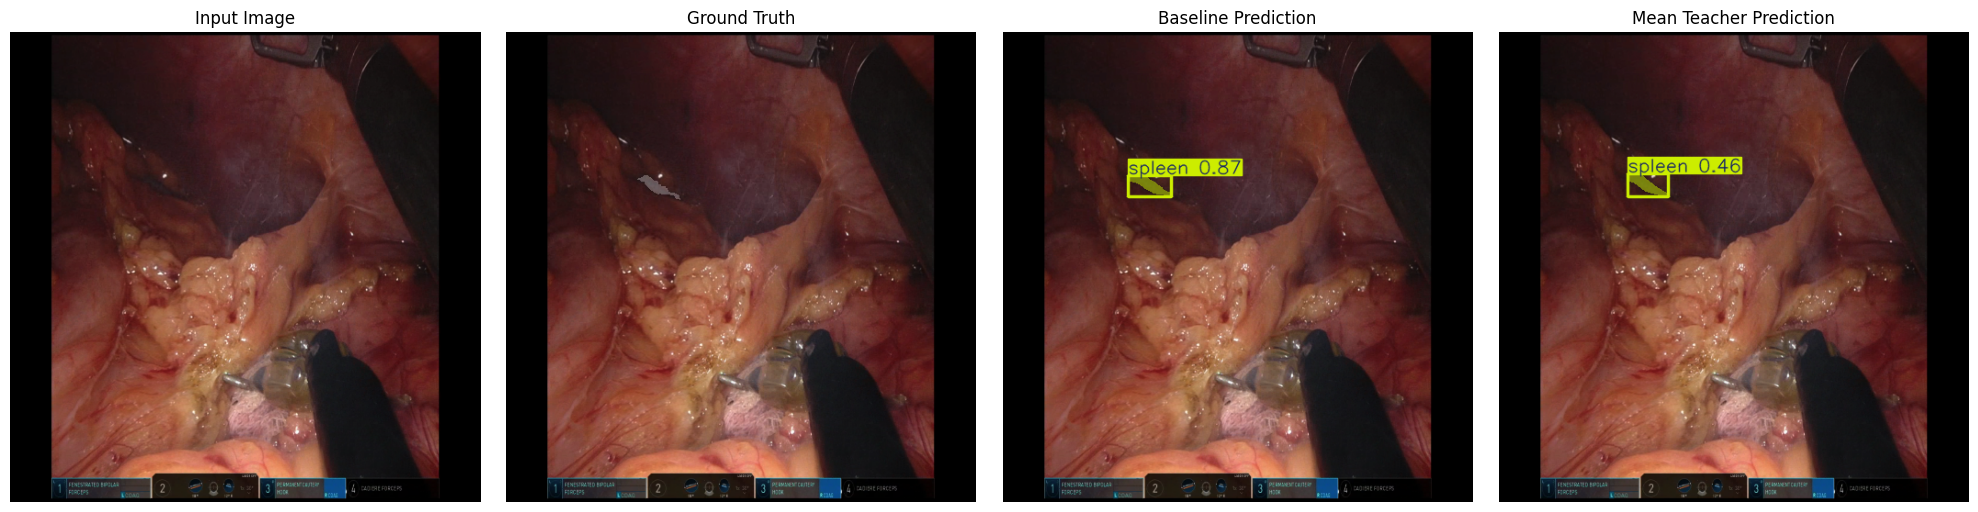

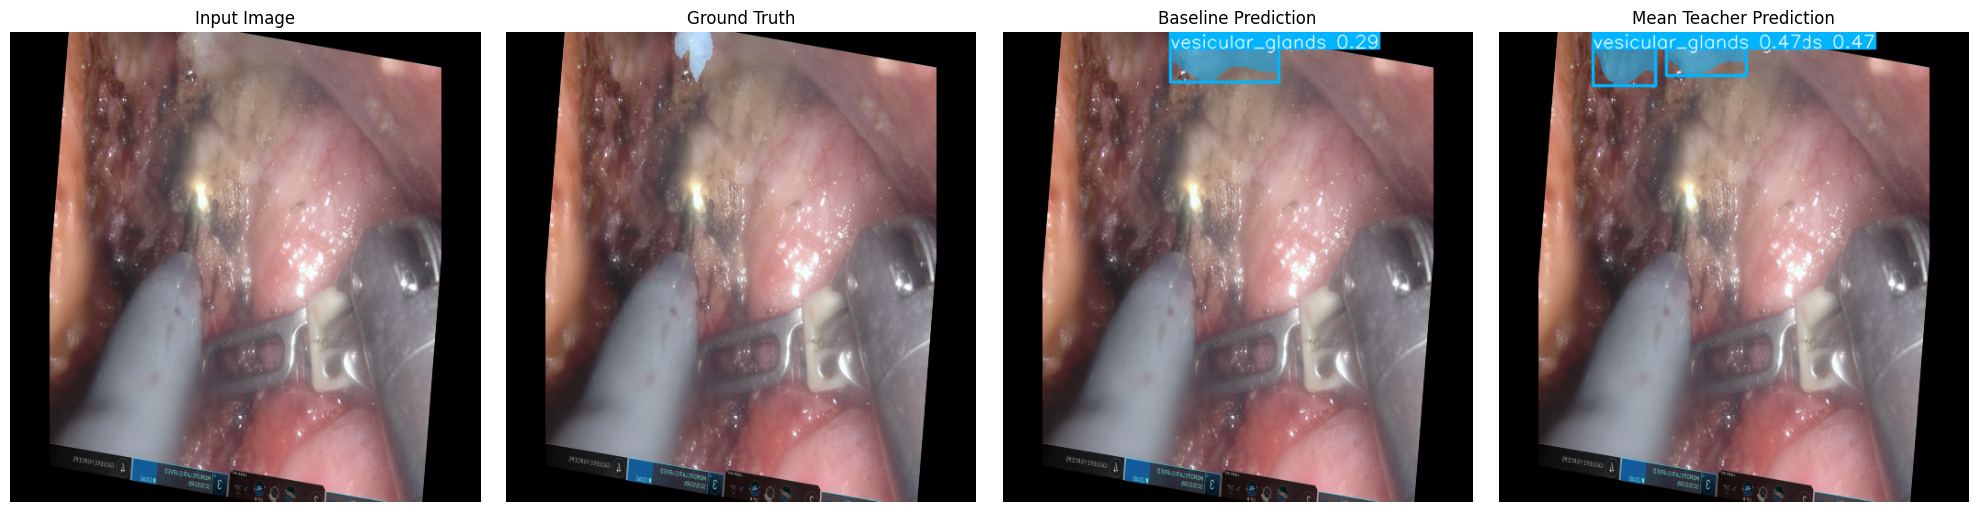

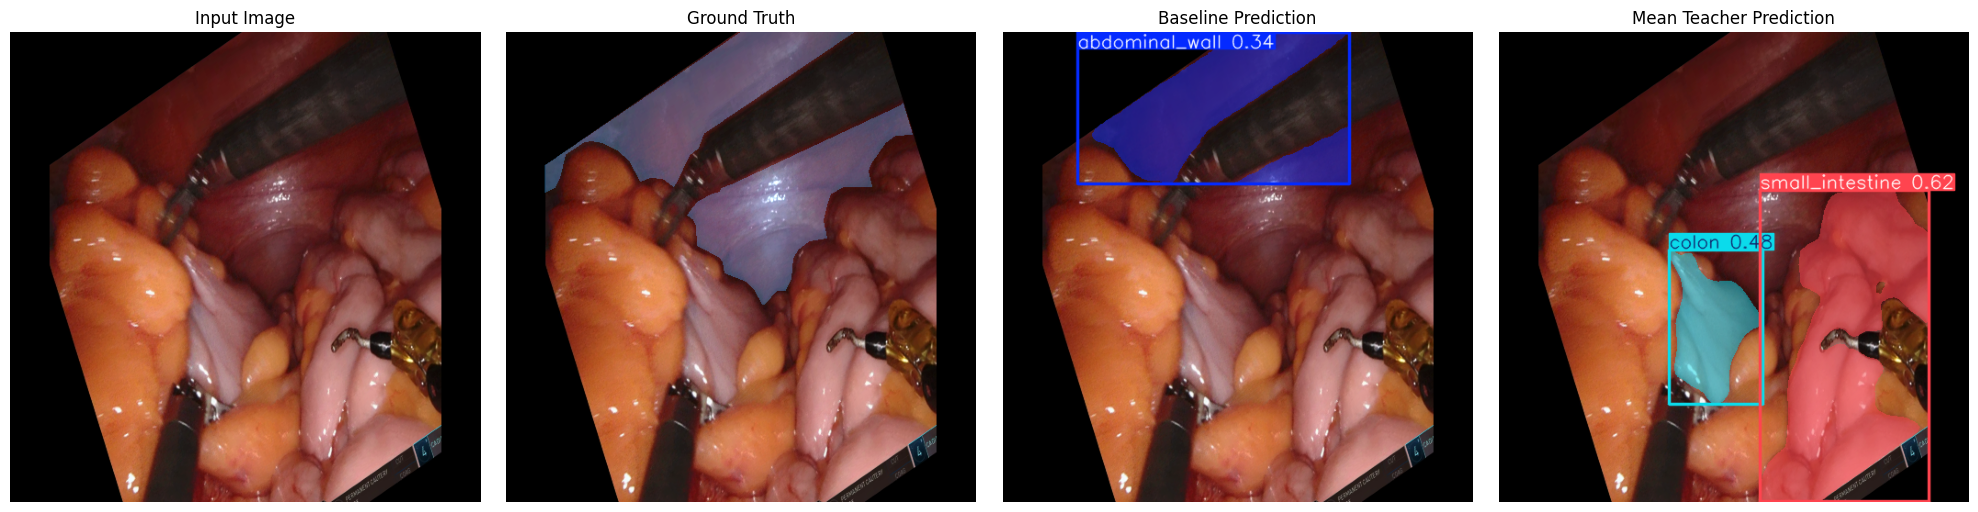

In [7]:
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import os

# Function to plot ground truth masks
def plot_ground_truth(image_rgb, img_file_name, labels_base_dir, class_names, ax):
    img_name_without_ext = os.path.splitext(img_file_name)[0]
    label_path = os.path.join(labels_base_dir, 'test', f'{img_name_without_ext}.txt')

    annotated_image = image_rgb.copy()
    h, w, _ = image_rgb.shape

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        for line in lines:
            parts = list(map(float, line.strip().split()))
            class_id = int(parts[0])
            segment = np.array(parts[1:]).reshape(-1, 2)
            segment[:, 0] *= w
            segment[:, 1] *= h
            segment = segment.astype(np.int32)
            
            # Get a unique color for each class, cycling through tab10
            color_idx = class_id % plt.cm.get_cmap('tab10').N
            color_norm = plt.cm.get_cmap('tab10')(color_idx)[:3] # Normalized RGB (0-1)
            color_rgb = (np.array(color_norm) * 255).astype(np.uint8).tolist() # Matplotlib expects RGB [R, G, B]

            # Create mask overlay
            mask_overlay = np.zeros_like(image_rgb, dtype=np.uint8)
            cv2.fillPoly(mask_overlay, [segment], color_rgb)
            
            # Add weighted for transparency
            annotated_image = cv2.addWeighted(annotated_image, 1, mask_overlay, 0.5, 0)
    
    ax.imshow(annotated_image)
    ax.set_title('Ground Truth')
    ax.axis('off')

test_imgs = random.sample(test_images, 5)

for img_file_name in test_imgs:
    fig, axes = plt.subplots(1, 4, figsize=(20, 5)) # 4 subplots: Input, GT, Baseline, Mean Teacher
    
    image_path = f'/kaggle/working/images/test/{img_file_name}'
    image_bgr = cv2.imread(image_path) # Read in BGR
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB) # Convert to RGB for initial display and plot function input
    
    # 1. Input Image
    axes[0].imshow(image_rgb)
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    # 2. Ground Truth
    plot_ground_truth(image_rgb, img_file_name, '/kaggle/working/labels', data_yaml['names'], axes[1])

    # Common prediction parameters
    predict_params = dict(conf=0.25, iou=0.5, retina_masks=True, imgsz=416, verbose=False)

    # 3. Baseline Prediction
    res_base = model_baseline.predict(image_path, **predict_params)
    if res_base and res_base[0].masks is not None:
        annotated_img_base_bgr = res_base[0].plot(img=image_bgr.copy())
        annotated_img_base_rgb = cv2.cvtColor(annotated_img_base_bgr, cv2.COLOR_BGR2RGB)
        axes[2].imshow(annotated_img_base_rgb)
    else:
        axes[2].imshow(image_rgb) # show original if no detections
        axes[2].text(0.5, 0.5, 'No detections', horizontalalignment='center', verticalalignment='center', transform=axes[2].transAxes, color='red', fontsize=12)
    axes[2].set_title('Baseline Prediction')
    axes[2].axis('off')

    # 4. Mean Teacher Prediction
    res_mt = model_mt.predict(image_path, **predict_params)
    if res_mt and res_mt[0].masks is not None:
        annotated_img_mt_bgr = res_mt[0].plot(img=image_bgr.copy())
        annotated_img_mt_rgb = cv2.cvtColor(annotated_img_mt_bgr, cv2.COLOR_BGR2RGB)
        axes[3].imshow(annotated_img_mt_rgb)
    else:
        axes[3].imshow(image_rgb) # show original if no detections
        axes[3].text(0.5, 0.5, 'No detections', horizontalalignment='center', verticalalignment='center', transform=axes[3].transAxes, color='red', fontsize=12)
    axes[3].set_title('Mean Teacher Prediction')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()

## Discussion

Semi-supervised learning improves segmentation by leveraging unlabeled data, reducing the need for extensive annotations. Pseudo-labeling was effective but may introduce noise. Mean Teacher provided stable training through EMA. FixMatch excelled with augmentations. Unlabeled data helped in generalization. Challenges include hyperparameter tuning and computational cost.

## Conclusion

This notebook demonstrated SSL for instance segmentation, showing improvements over supervised baseline.